In [17]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from loader_clone import create_loaders

In [18]:
_, loader = create_loaders()

full_genres_embeddings = np.load('genres_embeddings.npy')
full_plot_embeddings = np.load('plot_embeddings.npy')

2017


c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\static\datasets\ml-latest\loader_clone.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loader.ratings_df.loc[:, "ratings_per_year"] = loader.ratings_df['movieId'].map(loader.ratings_df['movieId'].value_counts()) / loader.ratings_df['movieId'].map(movies_df_indexed["age"])


Ratings shape after filtering: (3536742, 5), n_users = 9612, n_items = 1525
2017


c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\static\datasets\ml-latest\loader_clone.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loader.ratings_df.loc[:, "ratings_per_year"] = loader.ratings_df['movieId'].map(loader.ratings_df['movieId'].value_counts()) / loader.ratings_df['movieId'].map(movies_df_indexed["age"])


Ratings shape after filtering: (8146440, 5), n_users = 34683, n_items = 9456


## Diversity phase

In diversity phase, we want to show pairs of movies that are similar in genres but different in plot, and vice versa. And let them rate how diverse they are.


### Genres 

To find similar movie pairs that share the same genres but have different plots is fairly easy. We have the following seed movies, covering a variety of genres:

- The Godfather - 858
- The Matrix - 2571 
- The Incredibles - 8961
- The Proposal - 69406
- Tyson - 69458

As a pair we select the most similar movies by genre embedding (same genres) 

```txt

Movie ID: 858
Most similar by genre: 
Boyz N the Hood (1991)
Crime, Drama
 (Similarity: 1.0000)

Most similar by plot: Godfather: Part III, The (1990)
Follows the lives of three young males living in the Crenshaw ghetto of Los Angeles, dissecting questions of race, relationships, violence, and future prospects.
 (Similarity: 0.5636)

```


#### Detour, normalization of similarity for plots?

Noticed that the similarity for plots tends to be in between 0.3 and 0.5, and very few movies have similarity above or below that range. Since genre similarity is defined in 0-1 range, we should normalize the plot similarity to be in the same range.

First we analyze the distribution of plot similarity values.
We only select 1000 random movies. Since we calculate similarity for each movie with all other movies, it is computationally expensive to calculate for all movies used (10k). Number of pairs is 1000 * 999 / 2 = 499500, which is too much better than 40million pairs for all movies.



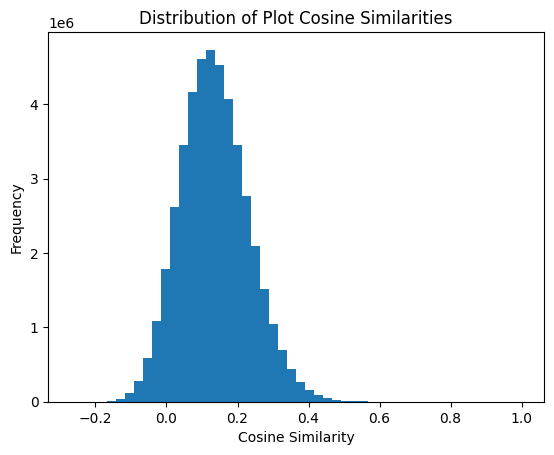

In [ ]:

sim_matrix = cosine_similarity(full_plot_embeddings)
triu_indices = np.triu_indices_from(sim_matrix, k=1) # avoid duplicates ij - ji
sim_scores = sim_matrix[triu_indices]

plt.hist(sim_scores, bins=50)
plt.title("Distribution of Plot Cosine Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

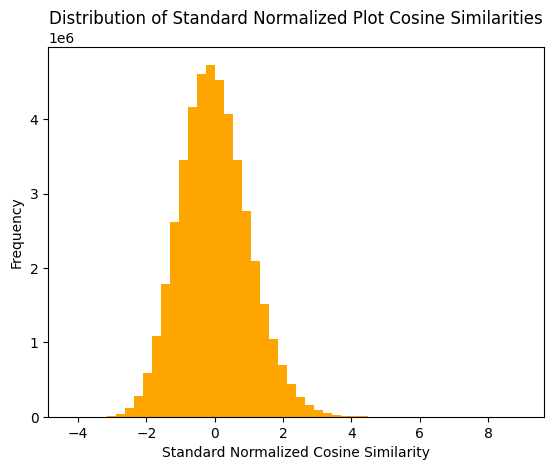

In [25]:
sim_scores_reshaped = sim_scores.reshape(-1, 1)
scaler = StandardScaler() # for z-score normalization (also called standardization)
sim_scores_std = scaler.fit_transform(sim_scores_reshaped).flatten()

plt.hist(sim_scores_std, bins=50, color='orange')
plt.title("Distribution of Standard Normalized Plot Cosine Similarities")
plt.xlabel("Standard Normalized Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

In [31]:
# NOT WORKING...
# def similarity_percentile(raw_sim, scaler):
#     """Return percentile (0–1) of a similarity score"""
#     z = scaler.transform([[raw_sim]])[0, 0]
#     return norm.cdf(z)

# NOT WORKING...
# def similarity_percentile(raw_sim, sample_scores):
#     return np.mean(sample_scores < raw_sim)

min_sim = sim_scores.min()
max_sim = sim_scores.max()

def similarity_score(raw_sim, min_val, max_val):
    return (raw_sim - min_val) / (max_val - min_val + 1e-8)



The distribution is bell shaped - we can use z-score normalization to map the values to 0-1 range. 



In [27]:
movies = loader.movies_df

genre_movie_ids = [858, 2571, 8961, 69406, 69458]

genre_movies = movies[movies['movieId'].isin(genre_movie_ids)]
genre_movies

,movieId,title,genres,plot,year
443,858,"Godfather, The (1972)","Crime, Drama",The aging patriarch of an organized crime dyna...,1972
1375,2571,"Matrix, The (1999)","Action, Sci-Fi, Thriller",When a beautiful stranger leads computer hacke...,1999
3660,8961,"Incredibles, The (2004)","Action, Adventure, Animation, Children, Comedy","While trying to lead a quiet suburban life, a ...",2004
5168,69406,"Proposal, The (2009)","Comedy, Romance",When New York editor Margaret faces deportatio...,2009
5170,69458,Tyson (2008),Documentary,"A mixture of original interviews, archival foo...",2008


In [ ]:
def find_most_similar(movie_id, base_embeddings, alt_embeddings, movies_df):
    index = movies_df[movies_df['movieId'] == movie_id].index[0]
    base_embedding = base_embeddings[index]
    alt_embedding = alt_embeddings[index]

    # Compute cosine similarity
    similarities = cosine_similarity([base_embedding], base_embeddings).flatten()

    # Set self-similarity to -1 to ignore it when taking the argmax
    similarities[index] = -1

    nearest_index = np.argmax(similarities)
    similar_movie = movies_df.iloc[nearest_index]
    base_similarity = similarities[nearest_index]

    alt_similarity = cosine_similarity([alt_embedding], [alt_embeddings[nearest_index]])[0][0]
    
    print(similar_movie['genres'])
    print(similar_movie['plot'])

    return similar_movie['movieId'], similar_movie['title'], base_similarity, alt_similarity

def print_similarity_info_genres(movie_ids, genre_embeddings, plot_embeddings, movies_df, min_sim, max_sim):
    for movie_id in movie_ids:
        similar_id, similar_title, genre_sim, plot_sim = find_most_similar(
            movie_id, genre_embeddings, plot_embeddings, movies_df
        )

        score = similarity_score(plot_sim, min_sim, max_sim)

        print(f"{movie_id}\t{similar_id}\t{similar_title[:20]:<20}\tGenreSim: {genre_sim:.4f}\tPlotSim: {plot_sim:.4f} MinMax-{score:.4f}")
        
print("GENRE PAIRS")
print_similarity_info_genres(genre_movie_ids, full_genres_embeddings, full_plot_embeddings, loader.movies_df, min_sim, max_sim)

print("PLOT PAIRS")
print_similarity_info_genres(genre_movie_ids, full_plot_embeddings, full_genres_embeddings, loader.movies_df, min_sim, max_sim)


PLOT PAIRS
Crime, Drama, Mystery, Thriller
Follows Michael Corleone, now in his 60s, as he seeks to free his family from crime and find a suitable successor to his empire.
858	2023	Godfather: Part III,	GenreSim: 0.5636	PlotSim: 0.7630 MinMax-0.8134
Action, Crime, Thriller
A computer programmer stumbles upon a conspiracy, putting her life and the lives of those around her in great danger.
2571	185	Net, The (1995)     	GenreSim: 0.6108	PlotSim: 0.8713 MinMax-0.8986
Action, Comedy, Fantasy
A group of inept amateur superheroes must try to save the day when a supervillain threatens to destroy a major superhero and the city.
8961	2723	Mystery Men (1999)  	GenreSim: 0.6491	PlotSim: 0.7849 MinMax-0.8306
Comedy, Drama
Soon after her divorce, a fiction writer returns to her home in small-town Minnesota, looking to rekindle a romance with her ex-boyfriend who is now happily married and has a newborn daughter.
69406	91622	Young Adult (2011)  	GenreSim: 0.4760	PlotSim: 0.7875 MinMax-0.8326
Document

In [42]:
index = movies[movies['movieId'] == "69458"].index[0]
tyson = movies.iloc[index]
print(tyson)

IndexError: index 0 is out of bounds for axis 0 with size 0